## Figure 1c: Hierarchical clustering of drug-feature associations

This script prints Figure 1c: Hierarchical clustering of host and microbiome features affected by each drug in at least one patient group.

The features are separated into potential drug effects (discordant with disease associations) and severity markers (concordant with disease associations). 

Number of features of specific type affected by each drug falling into each category was used to cluster the drug effects. Pearson’s correlation was used as a distance metric for clustering. 

ACE: angiotensin converting enzyme; DPPIV: dipeptidyl peptidase 4; GLP-1: Glucagon-like peptide-1; PPI: proton pump inhibitor; SGLT2: sodium/glucose co-transporter 2.

Required file in the *input_data* folder:

- Supplementary_Tables_1_to_4_2019-09-13434.xlsx

Supplementary Tables 1 to 4 include information on the cohort characteristics and drug intake with source metadata. Source metadata for the MetaCardis cohort includes disease group, gender, age, study center, body mass index (BMI, kg/m2), alternative healthy eating index (aHEI), diet diversity score (DDS), and dietary approaches to stop hypertension (DASH), physical activity and manual work levels, and smoking status. Source data includes information on the drug intake, drug combinations, dosage and antibiotic use analyzed in the MetaCardis cohort.

- Supplementary_Table_6_2019-09-13434.xlsx

Supplementary Table 6: Features of microbiome, host and metabolome impacted by different drug groups and drug compounds. Results of drug group (or drug compound according to the ATC classification) assessment for its impact on host and microbiome features for each patient group. Compound comparison with Maier et al., Nature 2018, tab shows microbiome features negatively impacted by the drug treatment (for the ATC-level compounds) in at least one patient group, and bacterial species whose growth was inhibited by the same drug in the in vitro experiment.

Figure is based on the data from Supplementary Tables 4 and 6. 

In [1]:
#Load the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
# read drug-feature association files
fileFolder = './input_data/'
fileName = 'Supplementary_Table_6_2019-09-13434.xlsx'
sheetName = 'Drug group effect'

In [3]:
drugEffect = pd.read_excel(fileFolder + fileName,
                           sheet_name = sheetName)

In [4]:
# Read drug indication information from Supplementary Table 4
indicationFile = 'Supplementary_Tables_1_to_4_2019-09-13434.xlsx'
sheetName = 'ST 4'
indication_df =  pd.read_excel(fileFolder + indicationFile,
                               sheet_name = sheetName)

# fill gaps with previous indication
fill_indication = 'NaN'
for i in range(indication_df.shape[0]):
    if type(indication_df['Major indication drug category'].iloc[i])==str:
        fill_indication = indication_df['Major indication drug category'].iloc[i]
    else:
        indication_df['Major indication drug category'].iloc[i] = fill_indication

Extract information on conditions (parient group), congruence with disease (opposite or same direction of effect), and effectors (drugs).

In [5]:
effectors = list(set(drugEffect['Effector']))

In [6]:
# add feature type
drugEffect['Feature type'] = ['Host' 
                    if ('Serum' in drugEffect['Feature space'].iloc[i]) or 
                       ('Urine' in drugEffect['Feature space'].iloc[i]) or
                       ('Phenotype' in drugEffect['Feature space'].iloc[i])
                    else 'Micro'
                    for i in range(len(drugEffect.index))]

Get the list of unique feature spaces and types

In [7]:
feature_spaces = list(set(drugEffect['Feature space']))

In [8]:
feature_types =  list(set(drugEffect['Feature type']))

Create a dataframe with the information of how many features were associated with each drug (per feature type).

In [9]:
common_columns_congruence_feature_types = [ x + '_' + y 
                                           for y in feature_spaces
                             for x in ['Opposite', 'Same']
                            ]

drug_feature_df = pd.DataFrame(0, index = effectors, 
                    columns = common_columns_congruence_feature_types)

for cureffect in effectors:
    for curtype in feature_spaces:
        for congr in ['Opposite', 'Same']:
            curfeatures = drugEffect[
            (drugEffect['Effector']==cureffect) &
            (drugEffect['Congruence']==congr) &
            (drugEffect['Feature space']==curtype)]
            #curval = np.shape(curfeatures)[0]
            #######################################
            # ! calculate number of unique features (if they repeat across conditions)
            curfeatures = curfeatures['Feature display name']
            curval = len(set(curfeatures))
            if congr=='Opposite':
                curval = -curval
            drug_feature_df.loc[cureffect,
                                congr + '_' + curtype] = curval

### Plot microbiome features

Extract of subset of microbiome features 

In [10]:
plotdata = drug_feature_df.copy()
keepterm = 'Micro'
colkeep = [item for item in plotdata.columns if (not('Serum' in item) and
          not('Urine' in item) and not ('Phenotype' in item))]
plotdata = plotdata[colkeep]

In [11]:
plotdata.columns = [item.replace('MGS', 'nMGS') for item in plotdata.columns]
plotdata = plotdata.reindex(sorted(plotdata.columns), axis=1)
plotdata.index = [item.replace(' intake', '') for item in plotdata.index]

Create color scheme for drugs according to indication

In [12]:
indication_color_df = indication_df.set_index('Drug class', drop=True).copy()
indication_color_df = [indication_color_df['Major indication drug category']
                           [indication_color_df.index.str.find((x+' 1').split(' ')[0])>=0].values[0]
                 if sum(indication_color_df.index.str.find((x+' 1').split(' ')[0])>=0)>0 else x
                 for x in plotdata.index]

In [13]:
indication_color_df = ['PPI' if plotdata.index[i].find('PPI')==0 else indication_color_df[i]
                       for i in range(len(indication_color_df))]
indication_color_df = ['Antihypertensive' if item.lower().find('diuretic')>=0 else item
                       for item in indication_color_df] 
indication_color_df = ['Antithrombotic/anticoagulant' if item.find('Anti-thrombocyte')>=0 else item
                       for item in indication_color_df] 
indication_color_df = ['Antithrombotic/anticoagulant' if item.find('Anticoagulant')>=0 else item
                       for item in indication_color_df] 
indication_color_df = ['Antiarrhythmic' if item.find('Other antiarhythmetic')>=0 else item
                       for item in indication_color_df] 


Make color dictionary for drug indication (in hex format).

In [14]:
lut = {'Antiarrhythmic':'#cc79a7',
 'Antidiabetic':'#009e73',
 'Antidyslipidemic':'#f0e442',
 'Antihypertensive':'#d55e00',
 'Antithrombotic/anticoagulant':'#e69f00',
 'Gout drug':'#0072b2',
 'PPI':'#56b3e9'}

In [15]:
indication_color_df_color = [lut[item] for item in indication_color_df]

Plot the clustergram.

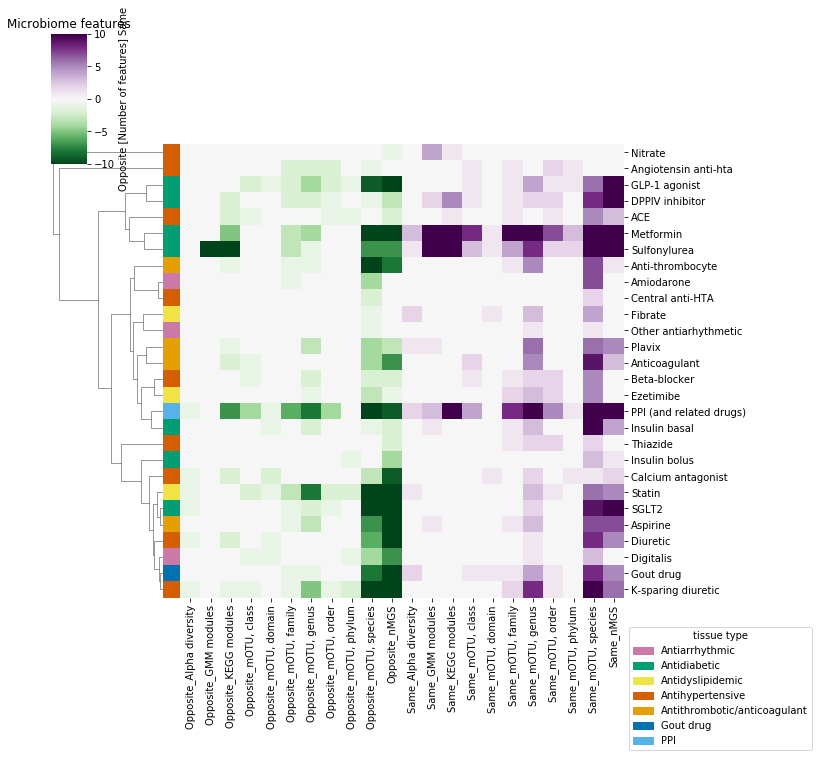

In [16]:
plotcmax = 10
g = sns.clustermap(plotdata,yticklabels=1, cmap = 'PRGn_r', #annot=False,#True,
                cbar_kws={'label': 'Opposite [Number of features] Same'},
                col_cluster=False,
                   vmin=-plotcmax, vmax=plotcmax,
                  metric= 'correlation',#'cityblock',#'euclidean',#''matching',#'cosine',#
                  row_colors=indication_color_df_color)
legend_TN = [mpatches.Patch(color=lut[c], label=c) for c in lut]
l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1,-0.2),
                       handles=legend_TN,frameon=True)
l2.set_title(title='tissue type',prop={'size':10})
plt.title('Microbiome features')


filename = "Fig1c_clustergram_drugs_features_" + keepterm
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.fonttype'] = 'none'
# UNCOMMENT TO PRINT TO FILE
# plt.savefig(fileFolder + filename + '.svg',
#             format='svg',
#             bbox_inches='tight')

# plt.savefig(fileFolder + filename + '.png',
#             format='png',
#             bbox_inches='tight')

#### Plot host festures

Select a subset of host features

In [17]:
plotdata = drug_feature_df.copy()
keepterm = 'Host'
colkeep = [item for item in plotdata.columns if not(not('Serum' in item) and
            not('Urine' in item) and not ('Phenotype' in item))]
plotdata = plotdata[colkeep]

In [18]:
plotdata.columns = [item.replace('MGS', 'nMGS') for item in plotdata.columns]
plotdata = plotdata.reindex(sorted(plotdata.columns), axis=1)
plotdata.index = [item.replace(' intake', '') for item in plotdata.index]

In [19]:
indication_color_df = indication_df.set_index('Drug class', drop=True).copy()
indication_color_df = [indication_color_df['Major indication drug category']
                           [indication_color_df.index.str.find((x+' 1').split(' ')[0])>=0].values[0]
                 if sum(indication_color_df.index.str.find((x+' 1').split(' ')[0])>=0)>0 else x
                 for x in plotdata.index]

In [20]:
indication_color_df = ['PPI' if plotdata.index[i].find('PPI')==0 else indication_color_df[i]
                       for i in range(len(indication_color_df))]
indication_color_df = ['Antihypertensive' if item.lower().find('diuretic')>=0 else item
                       for item in indication_color_df] 
indication_color_df = ['Antithrombotic/anticoagulant' if item.find('Anti-thrombocyte')>=0 else item
                       for item in indication_color_df] 
indication_color_df = ['Antithrombotic/anticoagulant' if item.find('Anticoagulant')>=0 else item
                       for item in indication_color_df] 
indication_color_df = ['Antiarrhythmic' if item.find('Other antiarhythmetic')>=0 else item
                       for item in indication_color_df] 


In [21]:
indication_color_df_color = [lut[item] for item in indication_color_df]

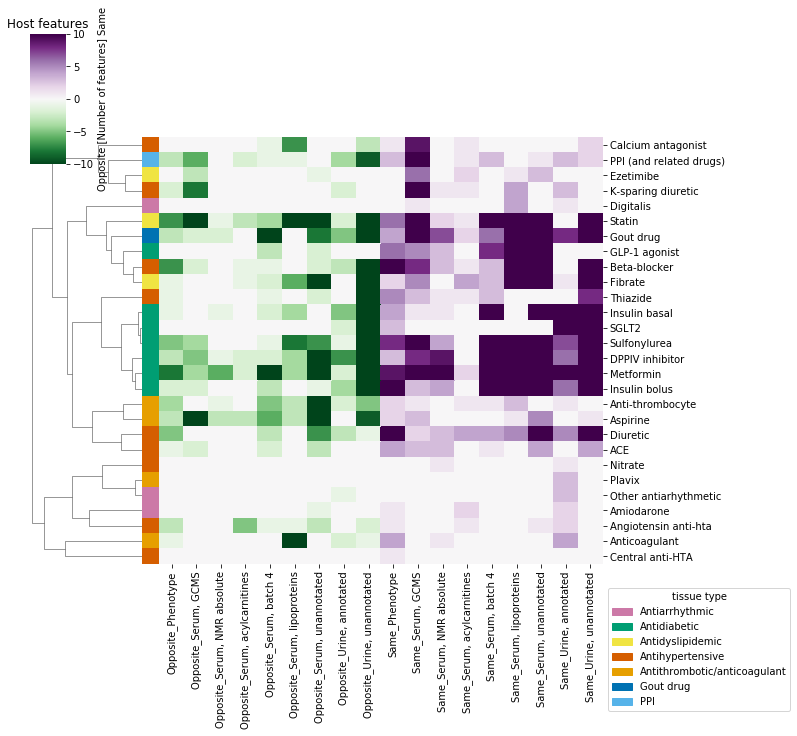

In [22]:
plotcmax = 10
g = sns.clustermap(plotdata,yticklabels=1, cmap = 'PRGn_r', #annot=False,#True,
                cbar_kws={'label': 'Opposite [Number of features] Same'},
                col_cluster=False,
                   vmin=-plotcmax, vmax=plotcmax,
                  metric= 'correlation',#'cityblock',#'euclidean',#''matching',#'cosine',#
                  row_colors=indication_color_df_color)
legend_TN = [mpatches.Patch(color=lut[c], label=c) for c in lut]
l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1,-0.2),
                       handles=legend_TN,frameon=True)
l2.set_title(title='tissue type',prop={'size':10})
plt.title('Host features')


filename = "Fig1c_clustergram_drugs_features_" + keepterm
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.fonttype'] = 'none'
# UNCOMMENT TO PRINT TO FILE
# plt.savefig(fileFolder + filename + '.svg',
#             format='svg',
#             bbox_inches='tight')

# plt.savefig(fileFolder + filename + '.png',
#             format='png',
#             bbox_inches='tight')

### Create summary table per drug

In [23]:
from collections import Counter

In [24]:
common_columns_congruence_feature_types = [ x + '_' + y 
                                           for y in feature_spaces
                             for x in ['Opposite', 'Same']
                            ]

drug_feature_df = pd.DataFrame(0, index = effectors, 
                    columns = common_columns_congruence_feature_types)

for cureffect in effectors:
    for curtype in feature_spaces:
        for congr in ['Opposite', 'Same']:
            curfeatures = drugEffect[
            (drugEffect['Effector']==cureffect) &
            (drugEffect['Congruence']==congr) &
            (drugEffect['Feature space']==curtype)]
            #curval = np.shape(curfeatures)[0]
            #######################################
            # ! calculate number of unique features (if they repeat across conditions)
            curfeatures = curfeatures['Feature display name']
            curval = len(set(curfeatures))
            drug_feature_df.loc[cureffect,
                                congr + '_' + curtype] = curval

In [25]:
# concatenate each feature space with either "opposite" or "same" 
# to distinguish potential drug effects from disease severity markers
common_columns_congruence_feature_types = [ x + '_' + y 
                                           for y in feature_spaces
                             for x in ['Opposite', 'Same']
                            ]
# Create a summary dataframe of number of features per drug
drug_feature_multiple_group_df = pd.DataFrame(0, index = effectors, 
                    columns = common_columns_congruence_feature_types)

for cureffect in effectors:
    for curtype in feature_spaces:
        for congr in ['Opposite', 'Same']:
            curfeatures = drugEffect[
            (drugEffect['Effector']==cureffect) &
            (drugEffect['Congruence']==congr) &
            (drugEffect['Feature space']==curtype)]
            #curval = np.shape(curfeatures)[0]
            #######################################
            # ! calculate number of unique features (if they repeat across conditions)
            curfeatures = curfeatures['Feature display name']
            curval = Counter(curfeatures)
            drug_feature_multiple_group_df.loc[cureffect,
                    congr + '_' + curtype] = sum([item > 1 for item in list(curval.values())])

In [26]:
# add summary per host and microbiome feature, opposite and same
same_host = [item for item in drug_feature_df.columns if
             (item.find('Same')>=0) & 
             ((item.find('Serum')>=0) | (item.find('Urine')>=0) | (item.find('Phenotype')>=0))]
same_micro = [item for item in drug_feature_df.columns if
             (item.find('Same')>=0) & 
             (not((item.find('Serum')>=0) | (item.find('Urine')>=0) | (item.find('Phenotype')>=0)))]
opposite_host = [item for item in drug_feature_df.columns if
             (item.find('Opposite')>=0) & 
             ((item.find('Serum')>=0) | (item.find('Urine')>=0) | (item.find('Phenotype')>=0))]
opposite_micro = [item for item in drug_feature_df.columns if
             (item.find('Opposite')>=0) & 
             (not((item.find('Serum')>=0) | (item.find('Urine')>=0) | (item.find('Phenotype')>=0)))]
              

In [27]:
# Sum number of features
drug_feature_df['Host_features_same'] = drug_feature_df[same_host].sum(axis=1)
drug_feature_df['Microbiome_features_same'] = drug_feature_df[same_micro].sum(axis=1)
drug_feature_df['Host_features_opposite'] = drug_feature_df[opposite_host].sum(axis=1)
drug_feature_df['Microbiome_features_opposite'] = drug_feature_df[opposite_micro].sum(axis=1)

In [28]:
# Sum number of features of the same type per drug
drug_feature_multiple_group_df['Host_features_same'] = \
    drug_feature_multiple_group_df[same_host].sum(axis=1)
drug_feature_multiple_group_df['Microbiome_features_same'] = \
    drug_feature_multiple_group_df[same_micro].sum(axis=1)
drug_feature_multiple_group_df['Host_features_opposite'] = \
    drug_feature_multiple_group_df[opposite_host].sum(axis=1)
drug_feature_multiple_group_df['Microbiome_features_opposite'] = \
    drug_feature_multiple_group_df[opposite_micro].sum(axis=1)

In [29]:
# sort columns
drug_feature_df = drug_feature_df[sorted(drug_feature_df.columns)]
drug_feature_multiple_group_df = drug_feature_multiple_group_df[sorted(drug_feature_multiple_group_df.columns)]

In [30]:
# UNCOMMENT TO PRINT TO FILE
# Print to file
#drug_feature_df.to_csv('Supplementary_table_7_number_of_features_per_drug.csv')
#drug_feature_multiple_group_df.to_csv('Supplementary_table_7_number_of_features_per_drug_multiple_groups.csv')


In [32]:
import pkg_resources
import sys

#print package versions
print('Sesssion info:')
print('Python: ', sys.version)
print('numpy: ', pkg_resources.get_distribution('numpy').version)
print('pandas: ', pkg_resources.get_distribution('pandas').version)
print('matplotlib: ', pkg_resources.get_distribution('matplotlib').version)
print('seaborn: ', pkg_resources.get_distribution('seaborn').version)

Sesssion info:
Python:  3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
numpy:  1.18.1
pandas:  1.0.3
matplotlib:  3.1.3
seaborn:  0.10.0
